In [1]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift
import math

In [2]:
BASE_DIR = '/content/drive/MyDrive/final_project'
os.chdir(BASE_DIR)

### **dataset A** 

In [3]:
print('current directory: ', os.getcwd())
data_path = os.path.join(BASE_DIR, 'data', 'A')

current directory:  /content/drive/MyDrive/final_project


In [5]:
!unzip "/content/drive/MyDrive/final_project/data/A/norm.zip" -d "/content/drive/MyDrive/final_project/data/A/norm"

Archive:  /content/drive/MyDrive/final_project/data/A/norm.zip
replace /content/drive/MyDrive/final_project/data/A/norm/S154W1.eea? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/final_project/data/A/norm/S154W1.eea  
  inflating: /content/drive/MyDrive/final_project/data/A/norm/S155W1.eea  
  inflating: /content/drive/MyDrive/final_project/data/A/norm/s157w1.eea  
  inflating: /content/drive/MyDrive/final_project/data/A/norm/s158w1.eea  
  inflating: /content/drive/MyDrive/final_project/data/A/norm/S163W1.eea  
  inflating: /content/drive/MyDrive/final_project/data/A/norm/S164W1.eea  
  inflating: /content/drive/MyDrive/final_project/data/A/norm/S165W1.eea  
  inflating: /content/drive/MyDrive/final_project/data/A/norm/S167W1.eea  
  inflating: /content/drive/MyDrive/final_project/data/A/norm/S169W.eea  
  inflating: /content/drive/MyDrive/final_project/data/A/norm/s170w1.eea  
  inflating: /content/drive/MyDrive/final_project/data/A/norm/s173w1.eea  
  in

In [ ]:
!unzip "/content/drive/MyDrive/final_project/data/A/sch.zip" -d "/content/drive/MyDrive/final_project/data/A/sch"

In [4]:
norm_path = os.path.join(data_path, 'norm')
sch_path = os.path.join(data_path, 'sch')

In [5]:
norm_path

'/content/drive/MyDrive/final_project/data/A/norm'

**read the data from files**

In [6]:
def read_data(subjects_path):
  subjects_list = []
  for filename in os.listdir(subjects_path):
    with open(os.path.join(subjects_path, filename), 'r') as f:
      lines = f.readlines()
      subjects_list.append(lines)
  return subjects_list


def convert_to_numbers(sub_list):
  new_list = []
  for sub in sub_list:
    new_list.append([float(value) for value in sub])
  return new_list



healthy_subjects_str = read_data(norm_path)
sch_subjects_str  = read_data(sch_path)
healthy_subjects = convert_to_numbers(healthy_subjects_str)
sch_subjects = convert_to_numbers(sch_subjects_str)

**divide into 16 channels**

In [7]:
def segment_list(lst, segments=16):
  arr = np.array(lst)
  return np.array_split(np.array(arr), segments)

def divide_to_channels(subjects_list, segments=16):
  return [segment_list(subject, segments) for subject in subjects_list]
    

In [8]:
# (no. cases, 16, 7680)
sz_channels = divide_to_channels(sch_subjects)
hc_channels = divide_to_channels(healthy_subjects)

recording_len = sz_channels[0][0].shape[0]
print('length of each channel: ',recording_len)

len(sz_channels), len(hc_channels)

length of each channel:  7680


(45, 39)

In [9]:
from matplotlib import gridspec

colors = ['black', 'darkorange', 'blue', 'red', 
          'cyan', 'limegreen', 'dodgerblue', 'violet', 
          'slateblue', 'pink', 'peru', 'navy', 
          'gold', 'black', 'green', 'royalblue', 'yellow']

def plot_subject_channels(data, subject_index=0, n_channels=16):
  #plt.style.use('seaborn-pastel')
  fig = plt.figure(figsize=(15, 20), dpi=80)
  gs = gridspec.GridSpec(n_channels, 1) 

  for i in range(0, n_channels):
    ax = plt.subplot(gs[i])
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    line, = ax.plot(data[subject_index][i], color=colors[i])
    ax.set_yticklabels([])
    ax.set_ylabel(f'CH {i + 1}')
    plt.xlim([0, recording_len])

  # remove vertical gap between subplots
  plt.subplots_adjust(hspace=.0)
  plt.show()


16 channel plot of one  schizophernic subject


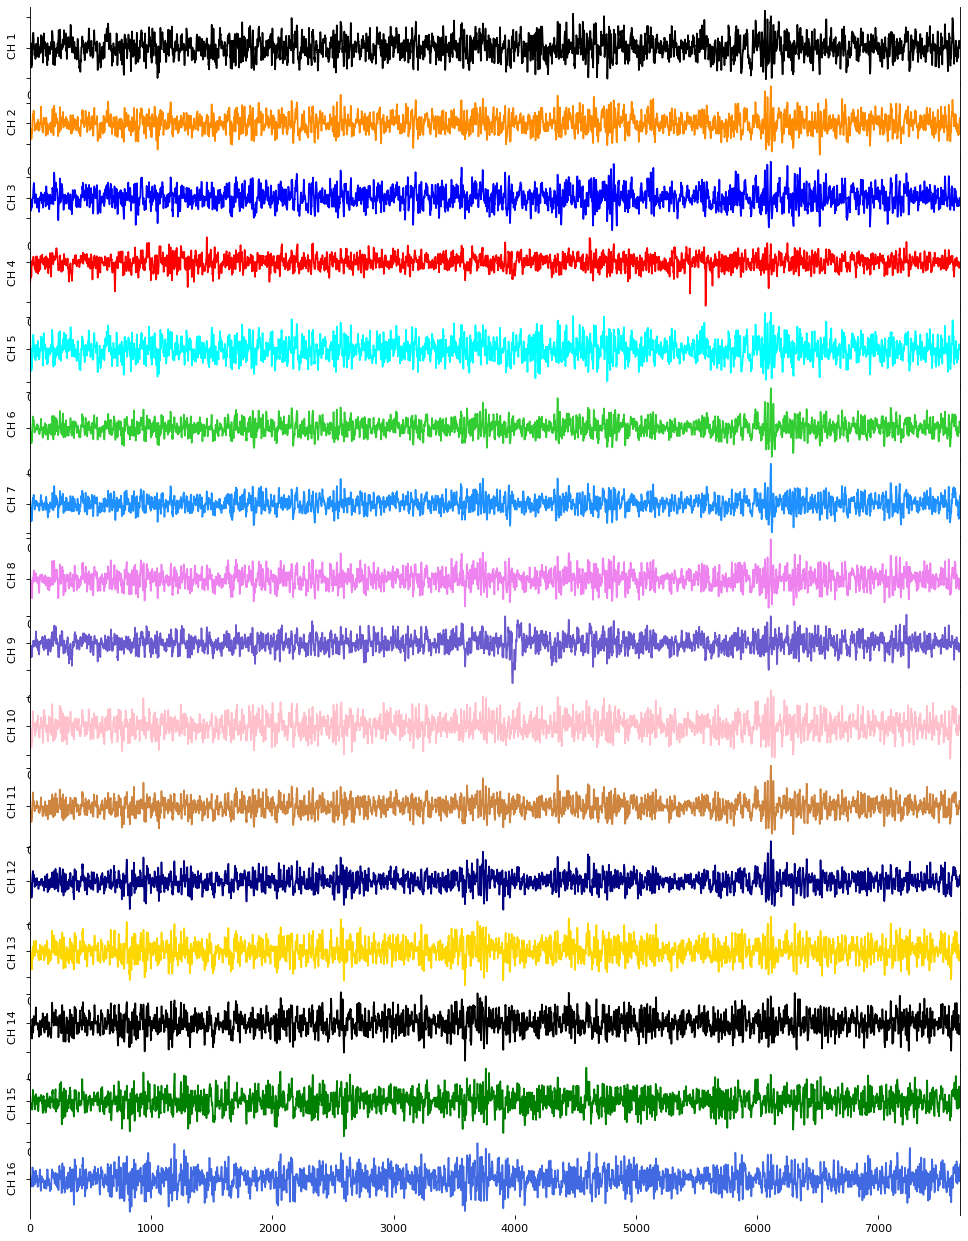

In [10]:
print("16 channel plot of one  schizophernic subject")
plot_subject_channels(sz_channels)

16 channel plot of one healthy subject


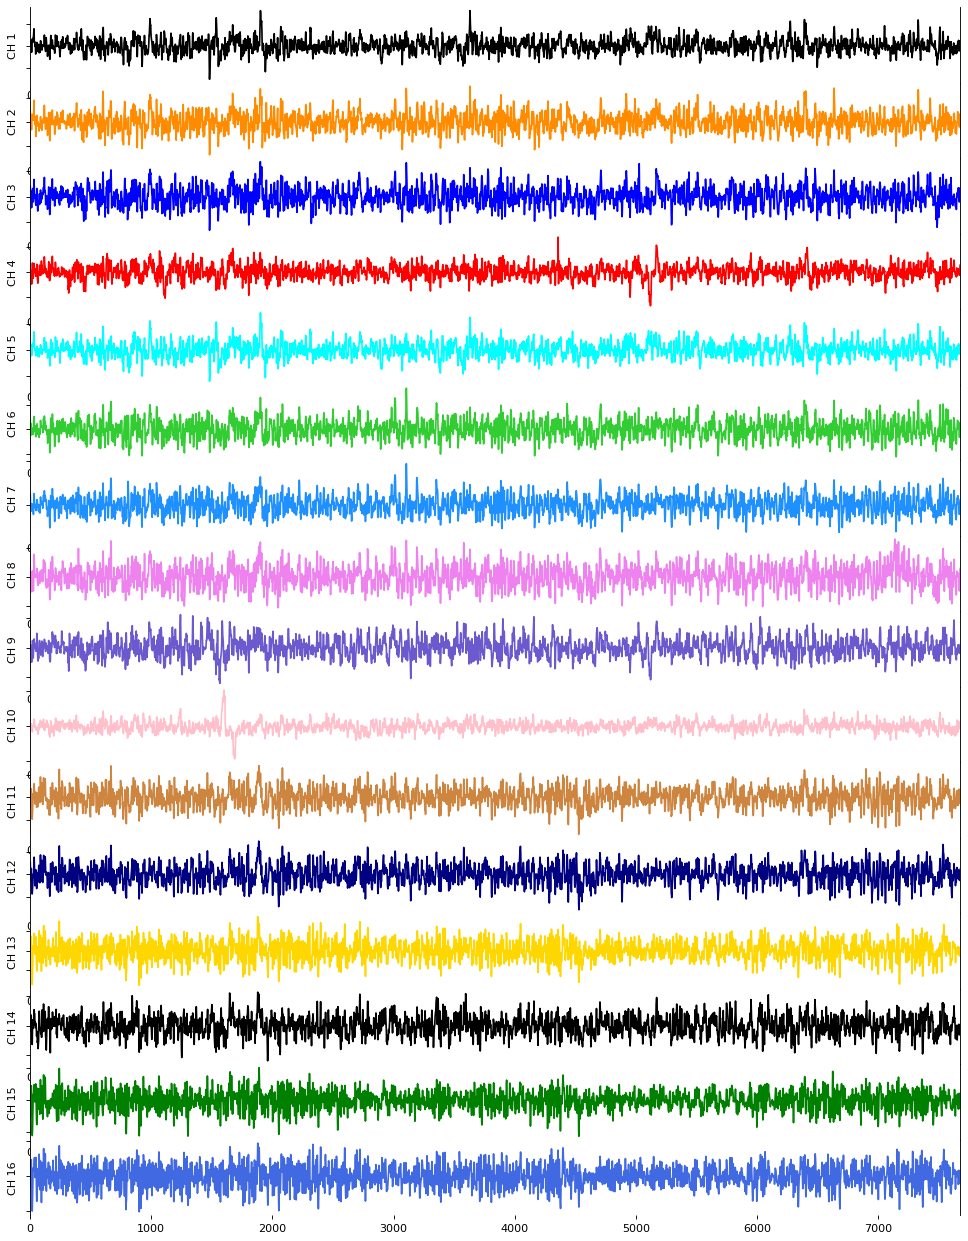

In [11]:
print("16 channel plot of one healthy subject")
plot_subject_channels(hc_channels)

total length of the recording is **1 minute** (7680 samples / 128 Hz sample rate) <br>

dividing each recording into 5 second segments **(128 x 5 x 16 channels)**

In [12]:
freq = 128
total_time = recording_len // freq
print(f'the recording is {total_time} seconds long and has total {recording_len} values')

the recording is 60 seconds long and has total 7680 values


In [13]:
def divide_time_segments(subject_list, time_window=5):
  n_segments = total_time // time_window
  return [np.split(channel, n_segments) for channel in subject_list]


def create_spectrogram_data(subject_list):
  new_subject_list = []
  for subject in subject_list:
    specs = []
    segment_channels = divide_time_segments(subject)
    array_of_arrays = np.array([np.array(channel) for channel in segment_channels])
    for i in range(0, array_of_arrays.shape[1]):
      spec_data = np.squeeze(array_of_arrays[:, i, :].reshape((1, -1)))
      specs.append(spec_data)
    new_subject_list.append(specs)
  return new_subject_list


hc_spectrogram_data = create_spectrogram_data(hc_channels)
sz_spectrogram_data = create_spectrogram_data(sz_channels)

spectrogram of a healthy subject: 



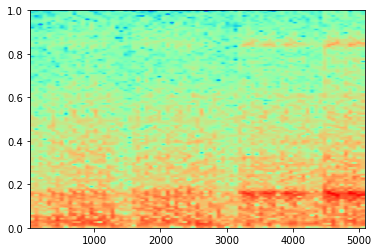

spectrogram of a schizophernia subject: 



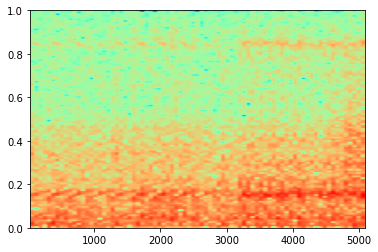

In [14]:
def create_spectrogram(data, impath='', save=False):
  plt.specgram(data, Fs=2, cmap="rainbow")
  if save:
    plt.axis('off')
    plt.savefig(impath, dpi=120, pad_inches=0.0, bbox_inches='tight')
  else: plt.show()


print('spectrogram of a healthy subject: \n')
create_spectrogram(hc_spectrogram_data[1][0])

print('spectrogram of a schizophernia subject: \n')
create_spectrogram(sz_spectrogram_data[1][0])

**Create and save images**

In [19]:
cwd = os.getcwd()
cwd

'/content/drive/MyDrive/final_project'

In [22]:
def create_images(path, subject_data):
  if not os.path.exists(os.path.join(cwd, path)):
    os.mkdir(path)
  for i, subject in enumerate(subject_data):
    for j, segment in enumerate(subject):
      filename = f'subject{i}-segment{j}'
      create_spectrogram(segment, impath=os.path.join(path, filename), save=True)

In [ ]:
create_images(os.path.join('out','SZ'), sz_spectrogram_data)

In [ ]:
create_images(os.path.join('out','HC'), hc_spectrogram_data)